In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Quick check to make sure the versions we are using are up to date

import tensorflow as tf
print(tf.__version__)
print(pd.__version__)

1.12.0
0.23.4


In [24]:
# We can set all important variables at the start

main_folder = 'C://Users/karim/Desktop/'
images_folder = main_folder +'clean_AMLSdataset_mediumset/'

EXAMPLE_PIC = images_folder + '1.png'
#EXAMPLE_PIC = 'C://Users/karim/1.png'


TRAINING_SAMPLES = 660
VALIDATION_SAMPLES = 170
TEST_SAMPLES = 170
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
NUM_EPOCHS = 15

In [4]:
# Import the csv file that includes the attribute for each picture
df_attr = pd.read_csv('clean_attribute_list_mediumset.csv')
df_attr.set_index('file_name', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0

#Display shape of attribute list
df_attr.shape

(1000, 5)

In [5]:
# Display the list of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 hair_color
1 eyeglasses
2 smiling
3 young
4 human


smiling    1
young      1
human      0
Name: 1.png, dtype: int64

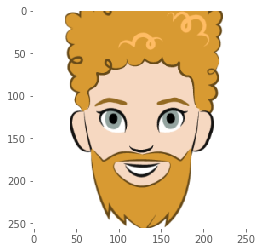

In [6]:
# An example plot that displays one of the 
# pictures in the dataset along with a couple of attributes

img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['smiling','young','human']] #some attributes

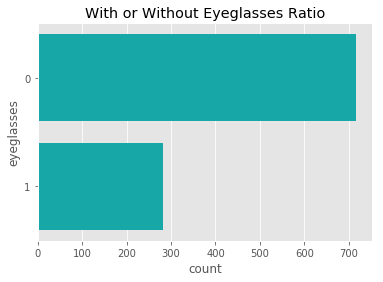

In [7]:
# Below we can have an idea about the consistency 
# of the attribute across the data

plt.title('With or Without Eyeglasses Ratio')
sns.countplot(y='eyeglasses', data=df_attr, color="c")
plt.show()

In [8]:
#Import the csv file that includes the partition chosen for the model

df_partition = pd.read_csv('clean_list_eval_partition_mediumset.csv')
print(df_partition.head(10))
print(df_partition.tail(10))

  file_name  partition
0     1.png          0
1     2.png          0
2     3.png          0
3     7.png          0
4     8.png          0
5     9.png          0
6    10.png          0
7    12.png          0
8    13.png          0
9    14.png          0
    file_name  partition
990  1093.png          2
991  1095.png          2
992  1096.png          2
993  1097.png          2
994  1098.png          2
995  1099.png          2
996  1101.png          2
997  1102.png          2
998  1103.png          2
999  1104.png          2


In [9]:
# Display the partitions
# 0 -> Training set
# 1 -> Validation set
# 2 -> Test set

df_partition['partition'].value_counts().sort_index()

0    660
1    170
2    170
Name: partition, dtype: int64

In [10]:
# Below we join the partition dataframe with the attributes dataframe

df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['eyeglasses'], how='inner')
#print(df_par_attr.head(50))
#print(df_par_attr.tail(50))
df_par_attr['eyeglasses'].value_counts().sort_index()



0    717
1    283
Name: eyeglasses, dtype: int64

In [11]:
df_training = df_par_attr[(df_par_attr['partition'] == 0)] 
print('TRAINING 0/1 RATIO')
df_training['eyeglasses'].value_counts().sort_index()


TRAINING 0/1 RATIO


0    484
1    176
Name: eyeglasses, dtype: int64

In [12]:
df_validation = df_par_attr[(df_par_attr['partition'] == 1)] 
print('VALIDATION 0/1 RATIO')
df_validation['eyeglasses'].value_counts().sort_index()


VALIDATION 0/1 RATIO


0    116
1     54
Name: eyeglasses, dtype: int64

In [13]:
df_testing = df_par_attr[(df_par_attr['partition'] == 2)] 
print('TESTING 0/1 RATIO')
df_testing['eyeglasses'].value_counts().sort_index()


TESTING 0/1 RATIO


0    117
1     53
Name: eyeglasses, dtype: int64

In [14]:
#Function allowing us to load the image, turn it into an array and reshape it
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

#Function allowing us to generate the dataframe containing the features of images
# that will then be passed into the model for training purposes.
def generate_df_TRAIN(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(50))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])

    #Feature extraction 
    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)

    return x_, y_

In [15]:
#The same function is repeated due to the fact that the consistency of attributes is different in each partition set

#Function allowing us to generate the dataframe containing the features of images
# that will then be passed into the model for validation purposes.
def generate_df_VAL(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(50))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])

    #Feature extraction
    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)

    return x_, y_

In [16]:
#The same function is repeated due to the fact that the consistency of attributes is different in each partition set

#Function allowing us to generate the dataframe containing the features of images
# that will then be passed into the model for testing purposes.
def generate_df_TEST(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(100))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])

    x_ = []
    y_ = []

    for index, target in df_.iterrows():
        im = cv2.imread(images_folder + index)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

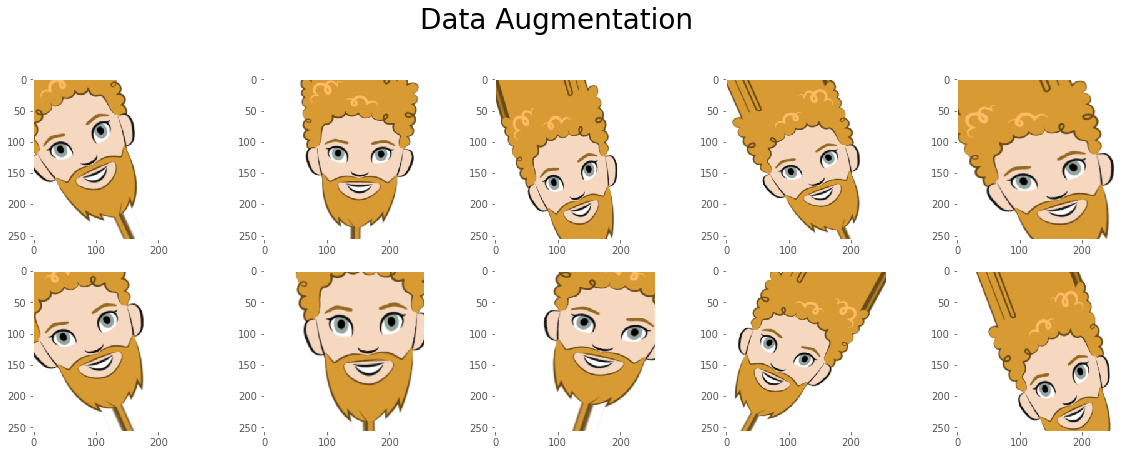

In [17]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded image
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(256, 256, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [18]:
# Here we generate the training data by sending the partition, here we have 0 which is equivalent to training set
# We send along as well the attribute and the number of training samples
x_train, y_train = generate_df_TRAIN(0, 'eyeglasses', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [19]:
# Similar to before, here we generate the Validation Data. Therefore we send the number 1 in between the brackets. 
x_valid, y_valid = generate_df_VAL(1, 'eyeglasses', VALIDATION_SAMPLES)


In [20]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [21]:
# Adding custom Layers in order to tailor the 
# output for either Binary or Multiclass Classification

x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [22]:
#Creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

#Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

#Compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [23]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.glassesdetection.hdf5', 
                               verbose=1, save_best_only=True)

In [25]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/15
42/41 [==============================] - 289s 7s/step - loss: 0.7157 - acc: 0.5267 - val_loss: 0.6168 - val_acc: 0.7800

Epoch 00001: val_loss improved from inf to 0.61677, saving model to weights.best.inc.glassesdetection.hdf5
Epoch 2/15
42/41 [==============================] - 284s 7s/step - loss: 0.6319 - acc: 0.6444 - val_loss: 0.5692 - val_acc: 0.7600

Epoch 00002: val_loss improved from 0.61677 to 0.56923, saving model to weights.best.inc.glassesdetection.hdf5
Epoch 3/15
42/41 [==============================] - 277s 7s/step - loss: 0.5621 - acc: 0.7454 - val_loss: 0.5326 - val_acc: 0.8000

Epoch 00003: val_loss improved from 0.56923 to 0.53264, saving model to weights.best.inc.glassesdetection.hdf5
Epoch 4/15
42/41 [==============================] - 276s 7s/step - loss: 0.4829 - acc: 0.8141 - val_loss: 0.4946 - val_acc: 0.8100

Epoch 00004: val_loss improved from 0.53264 to 0.49464, saving model to weights.best.inc.glassesdetection.hdf5
Epoch 5/15
42/41 [==============

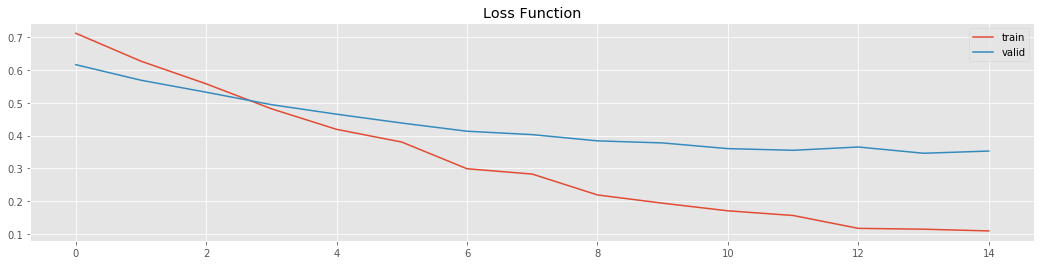

In [26]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

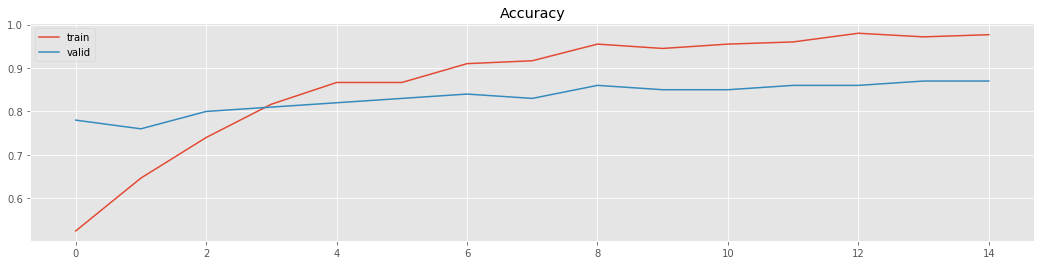

In [27]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [28]:
#load the best model
model_.load_weights('weights.best.inc.glassesdetection.hdf5')

In [29]:
# Similar to before, here we generate the Testing Data. Therefore we send the number 2 in between the brackets. 
x_test, y_test = generate_df_TEST(2, 'eyeglasses', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 77.3333%
f1_score: 0.7301587301587301


In [30]:
#dictionary to name the prediction
attribute_target = {0: 'Without Eyeglasses'
                , 1: 'With Eyeglasses'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display results in HTML for better visualisation
    
    '''

    attribute = 'With Eyeglasses'
    arrow_icon = "https://upload.wikimedia.org/wikipedia/commons/4/45/Arrow_Blue_Right_001.svg"
    
    #print(prediction)
    
    if prediction[1] <= 0.5:
        arrow_icon = "https://upload.wikimedia.org/wikipedia/commons/4/45/Arrow_Blue_Right_001.svg"
        attribute = 'Without Eyeglasses'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 5px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 10px; font-size: 10px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 25px; font-size: 10px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , arrow_icon
               , attribute
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , attribute_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [31]:
def attribute_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    


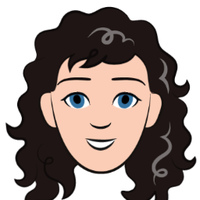

1



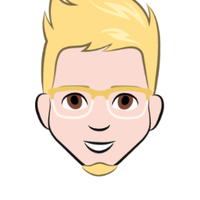

1



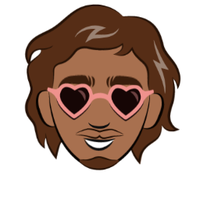

1



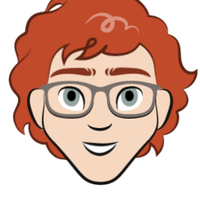

1



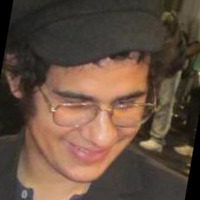

1



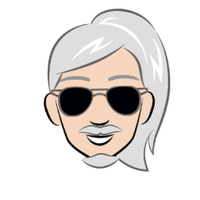

1



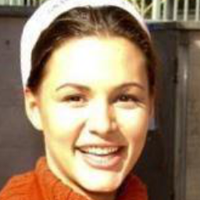

-1



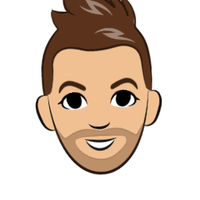

-1



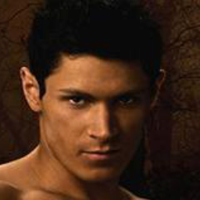

-1



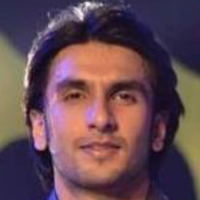

-1



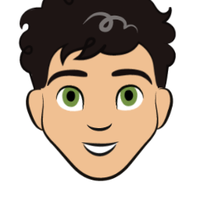

1



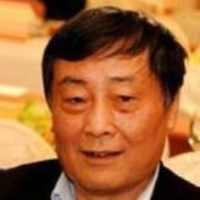

-1



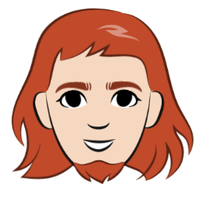

-1



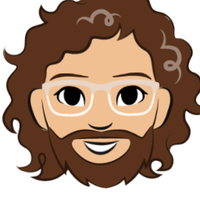

1



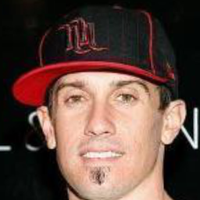

-1



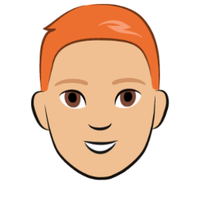

1



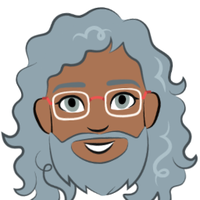

1



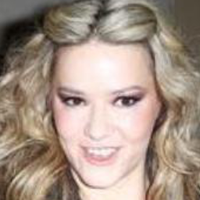

-1



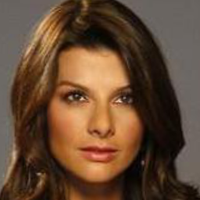

-1



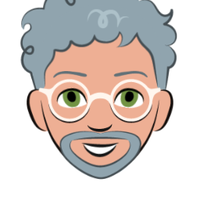

1



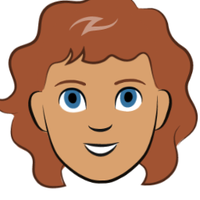

1



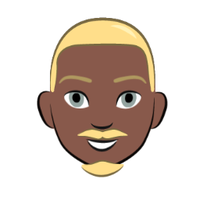

-1



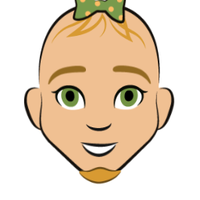

1



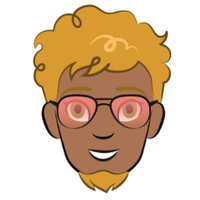

1



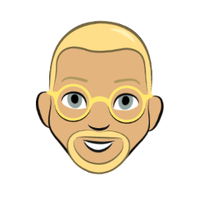

-1



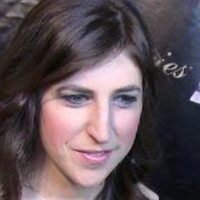

-1



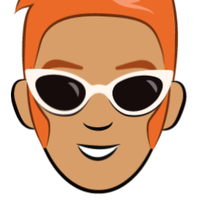

1



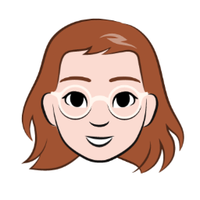

1



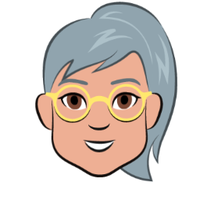

-1



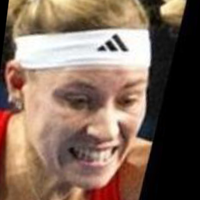

-1



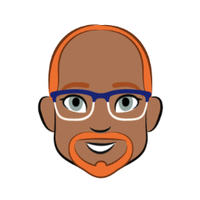

1



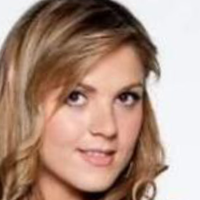

-1



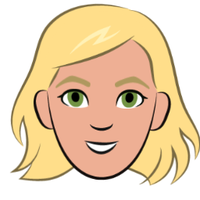

-1



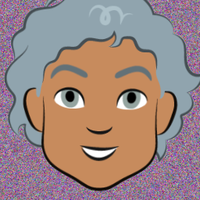

1



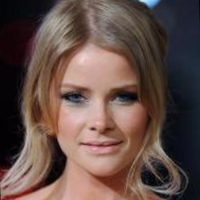

-1



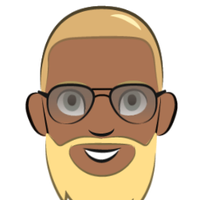

1



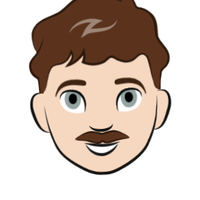

1



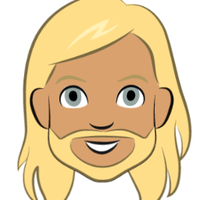

1



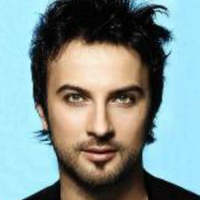

-1



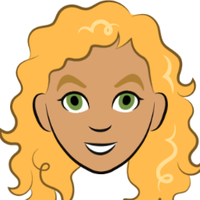

1



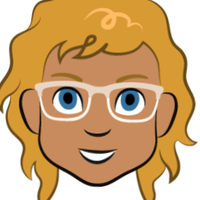

1



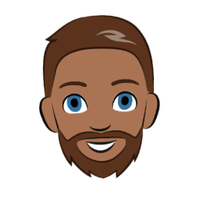

1



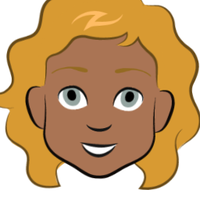

1



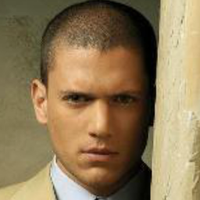

-1



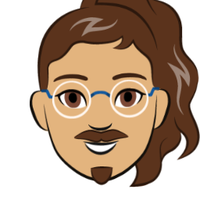

1



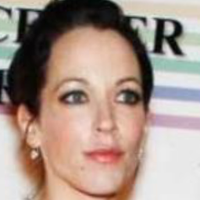

-1



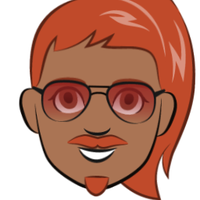

1



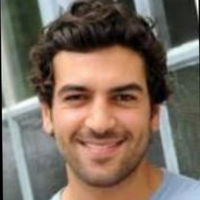

-1



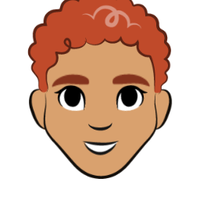

-1



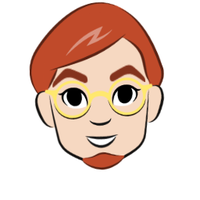

1



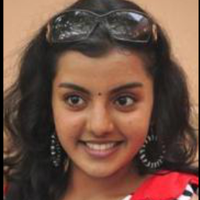

-1



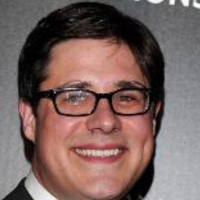

-1



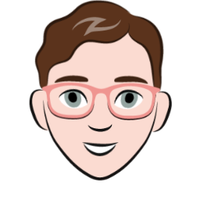

1



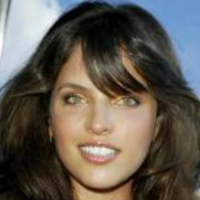

-1



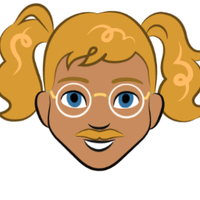

1



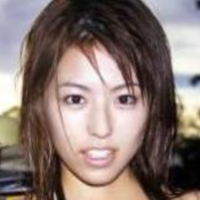

-1



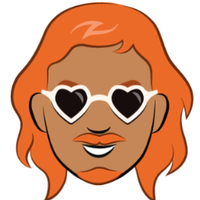

1



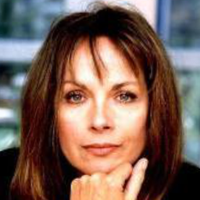

-1



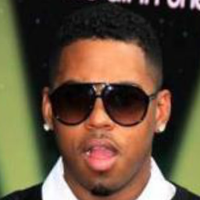

1



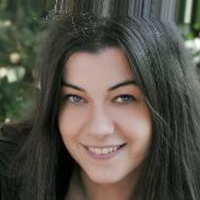

-1



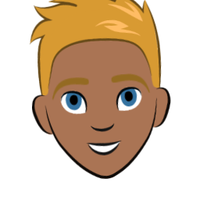

1



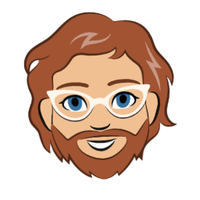

1



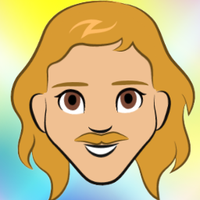

1



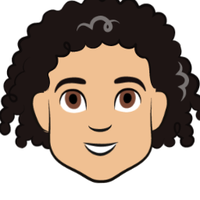

1



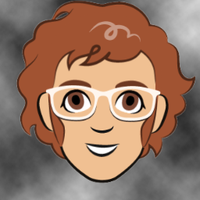

1



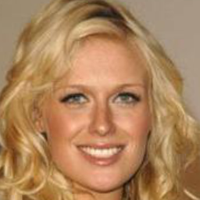

-1



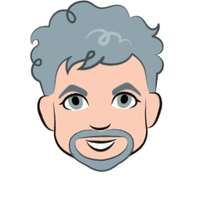

-1



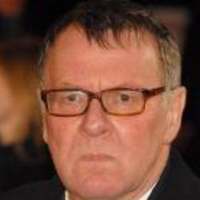

1



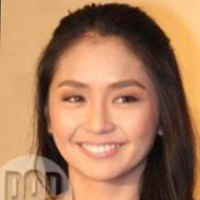

-1



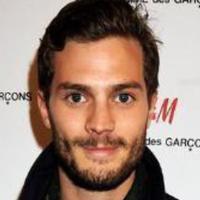

-1



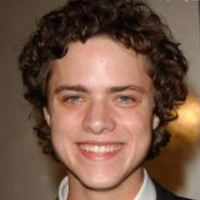

-1



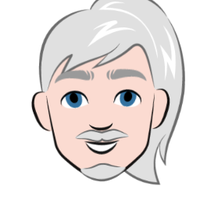

1



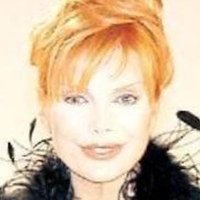

-1



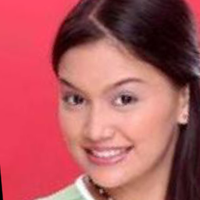

-1



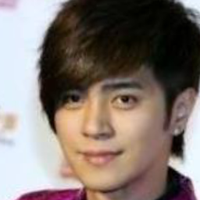

-1



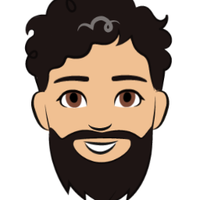

-1



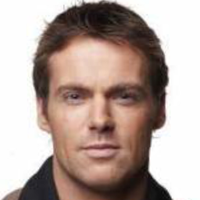

-1



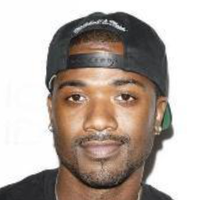

-1



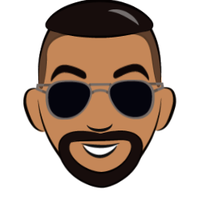

1



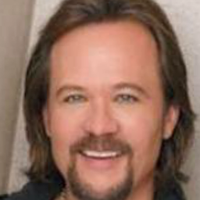

-1



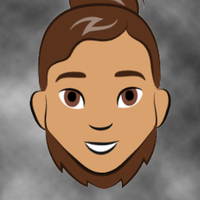

-1



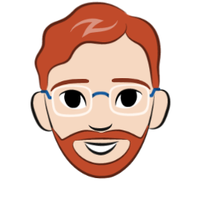

1



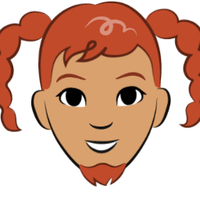

-1



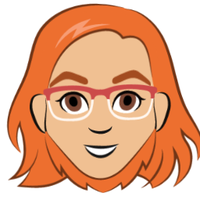

1



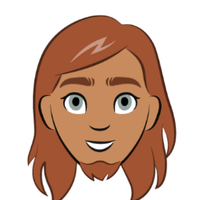

-1



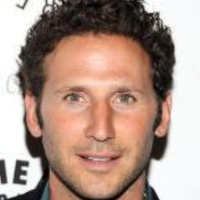

-1



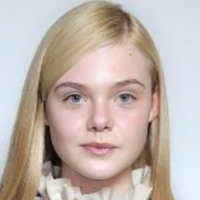

-1



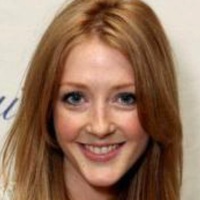

-1



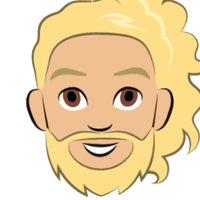

1



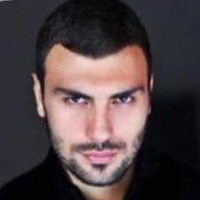

-1



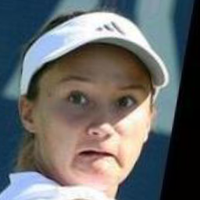

-1



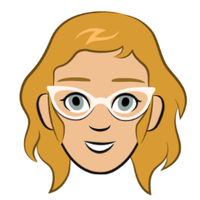

1



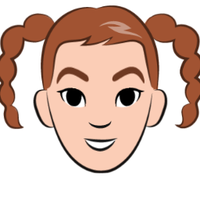

-1



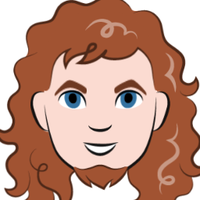

1



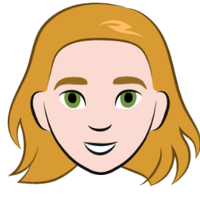

1



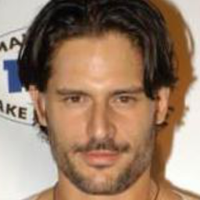

-1



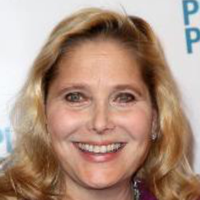

-1



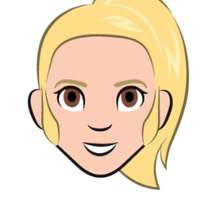

1



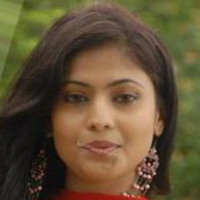

-1



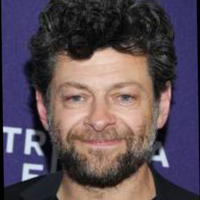

-1



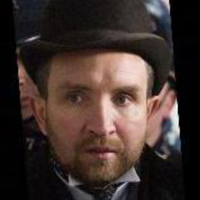

-1



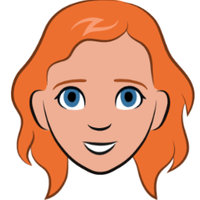

1



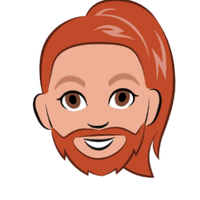

-1



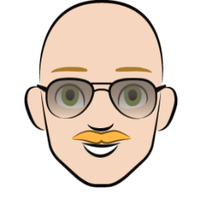

1



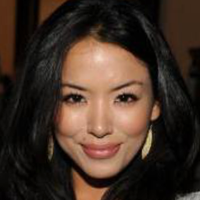

-1



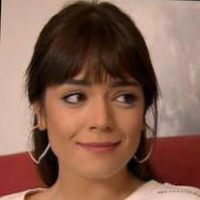

-1



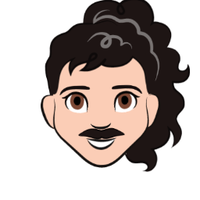

1



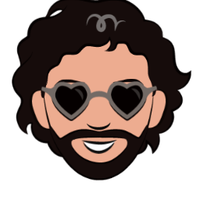

1



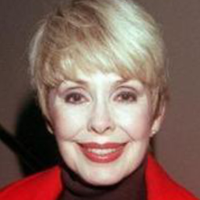

-1



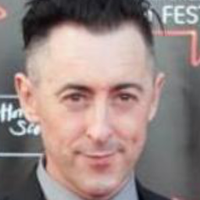

-1



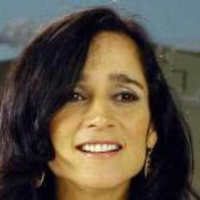

-1



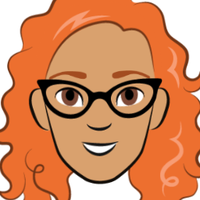

1



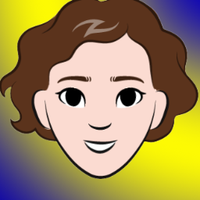

1



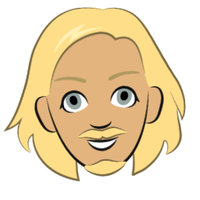

1



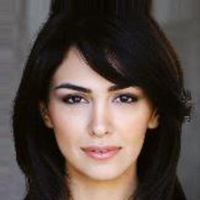

-1



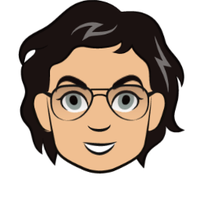

1



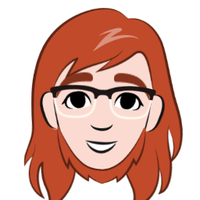

1



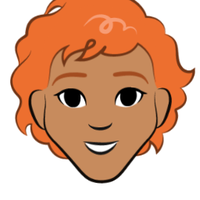

-1



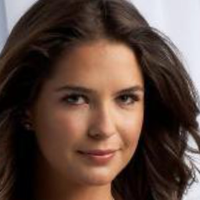

-1



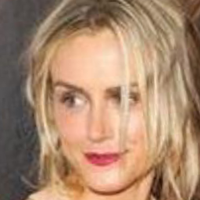

-1



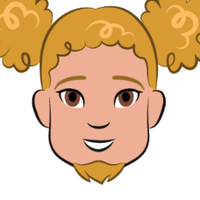

1



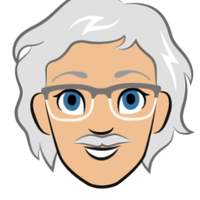

1



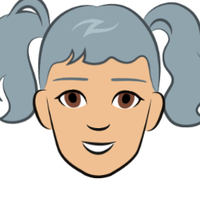

1



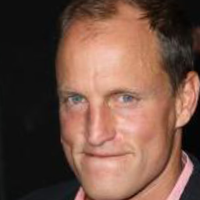

-1



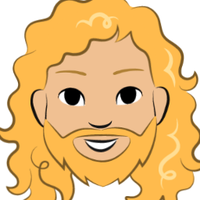

1



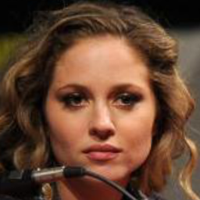

-1



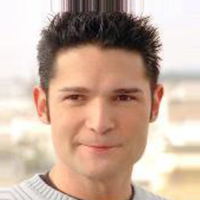

-1



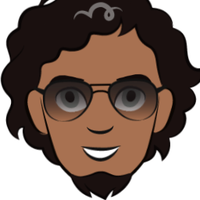

1



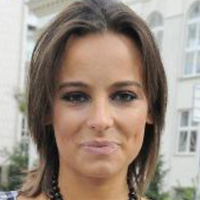

-1



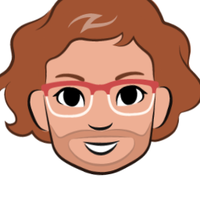

1



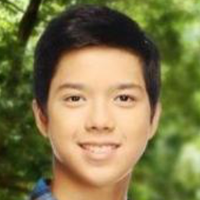

-1



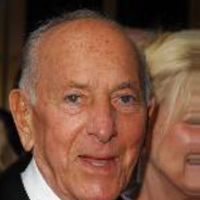

-1



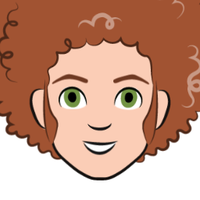

1



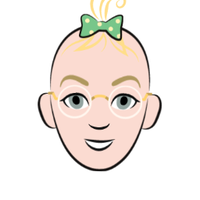

1



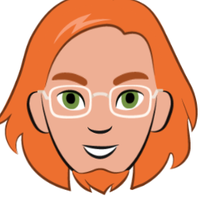

1



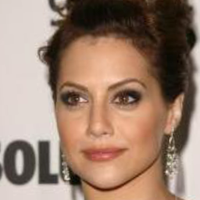

-1



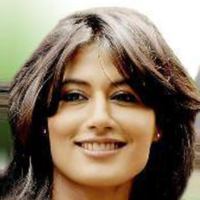

-1



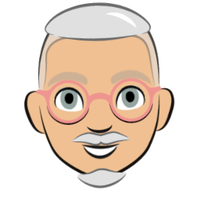

1



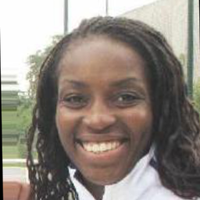

-1



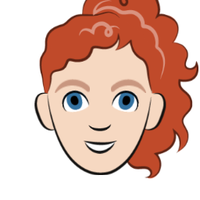

1



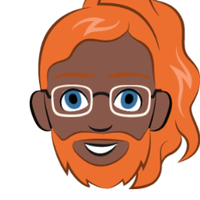

1



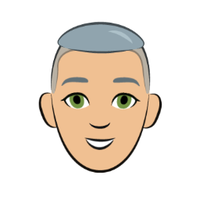

1



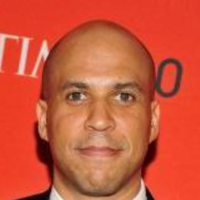

-1



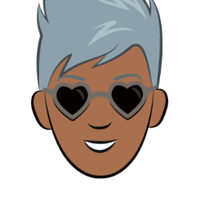

1



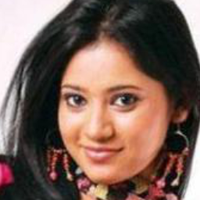

-1



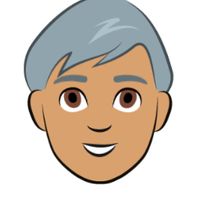

1



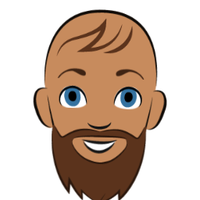

-1



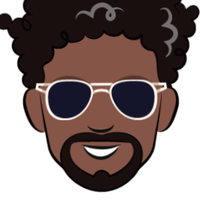

1



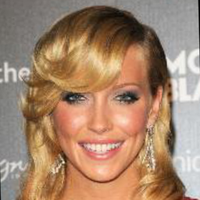

-1



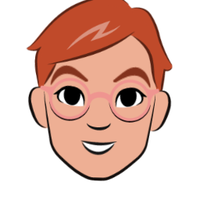

1


In [32]:
import csv

#Select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(150)

with open('task_3.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    filewriter.writerow([test_accuracy/100])
    
    for index, target in df_to_test.iterrows():
        result = attribute_prediction(images_folder + index)
       # print(result[0])
        highest_pred= np.amax(result)
       # print(highest_pred)

        pred_arr = result[0]
        #print(pred_arr[1])
                
        #display result
        display_result(images_folder + index, result[0], target['eyeglasses'])

        #print(index)

        if pred_arr[1] <= 0.5:
            negative = int(-1)
            print(negative)
            filewriter.writerow([index, negative])
        else:
            positive = int(1)
            print(positive)
            filewriter.writerow([index, positive])


